# TDEM Step off experiment

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This notebook was used to produce Figure 7 in Heagy and Oldenburg (2018). We run a top-casing time domain em experiment. One electrode is connected to the top of the casing and another is 1km away (on the surface). We then view the currents through time. 

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [1]:
# !pip install -r ../requirements.txt

In [2]:
# core python
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
from scipy.spatial import cKDTree
import os
import tarfile
import ipywidgets

# SimPEG, discretize
import discretize
from discretize import utils
from SimPEG.EM import TDEM
from SimPEG import Utils, Maps, versions
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casingSim

%matplotlib inline

The fields file that contains all of the currents on the mesh through time is quite large (2.3 GB) and takes a while to download. To lighten this, we have provided results that have been down-sampled through time. If `use_downsampled_resuts` is True, we will use those, otherwise, we download the entire fields file. 

In [3]:
use_downsampled_results = True
rerun = False

## model parameters

In [4]:
simDir = "TDEM_fields_response_1km"
# simDir_background = "TDEM_fields_response_1km_background"

In [5]:
# conductivities
sigma_air = 1e-5
sigma_back = 1e-2
sigma_casing = sigma_back
sigma_casing = 1e6

# relative permeability of the casing
mur_casing = 1.

# casing geometry
casing_diameter = 10e-2  
casing_t = 10e-3
casing_l = 1000

# cell size in the z-direction for the mesh
csz = 2.5 

Source electrode locations. The source runs along the $\theta = 90^{\circ}$ line

In [6]:
src_a = np.r_[casing_diameter / 2., np.pi/2, 0.]
src_b = np.r_[casing_l, np.pi/2, 0.]

In [7]:
model = casingSim.model.CasingInHalfspace(
    directory = simDir, 
    casing_d = casing_diameter,  # I use diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_back,
    src_a = src_a,
    src_b = src_b
)

Create the time-stepping for the forward simulation

In [8]:
timeSteps = [
    (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 17)
]

model.timeSteps = timeSteps

print("The latest time is {:1.1e}s".format(model.timeSteps.sum()))
print("There are {} time-steps in the simulation, {} are unique "
      "(this controls how many matrix factorizations need to be done)".format(
          len(model.timeSteps), len(np.unique(np.diff(model.timeSteps)))
      )
)

The latest time is 2.0e-01s
There are 187 time-steps in the simulation, 7 are unique (this controls how many matrix factorizations need to be done)


keep track of the models in a dictionary

In [9]:
model_names = ["casing"]
model_dict = dict(zip(model_names, [model]))

## Mesh

We set up a 3D cylindrical mesh for the simulations. Both the casing and background models will be run on the same mesh. 

In [10]:
# Theta discretization
hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

In [11]:
meshGen = casingSim.mesh.CasingMeshGenerator(
    directory = simDir, 
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = 100,
    domain_x = casing_l,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 8,
    npadz = 17,
    csz = csz,
)

In [12]:
print("The mesh has {} cells".format(meshGen.mesh.nC))

The mesh has 509712 cells


plot the mesh

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:63: RuntimeWarning: invalid value encountered in less
  mask = r < 0


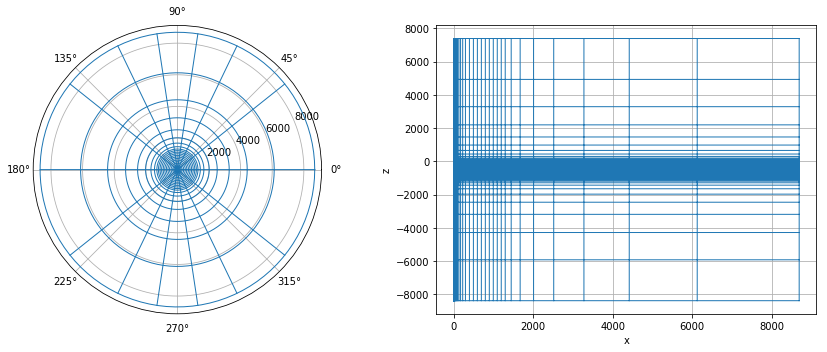

In [13]:
ax = meshGen.mesh.plotGrid()
# ax[0].set_rlim([50., 100.])
# ax[1].set_ylim([])

## Physical Properties

Now that we have a mesh and a model defined, we populate the mesh with physical properties

In [14]:
physprops_dict = {
    key: casingSim.model.PhysicalProperties(
        modelParameters=m, meshGenerator=meshGen
    )
    for key, m in model_dict.items() 
}


[(-1250.0, 10.0), (-1250.0, 10.0)]

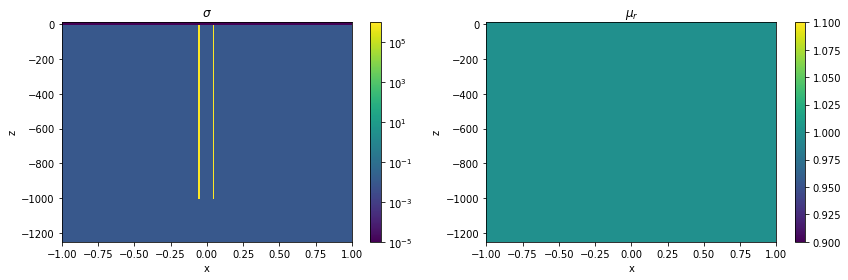

In [15]:
xlim = np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

ax = physprops_dict["casing"].plot(pcolorOpts = [{'norm':LogNorm()}, None])

[a.set_xlim(xlim) for a in ax]
[a.set_ylim(ylim) for a in ax]

## Survey

The source is a grounded source with one electrode at 1000m and the other electrode connected to the top of the casing. A wire connects them. Note that we will use H-J formulation t solve this problem, so the source is defined as current that goes through the faces of the mesh. 

In [16]:
src = casingSim.sources.TopCasingSrc(
    directory=simDir, 
    modelParameters=model, 
    meshGenerator=meshGen,
)

(-10.0, 10.0)

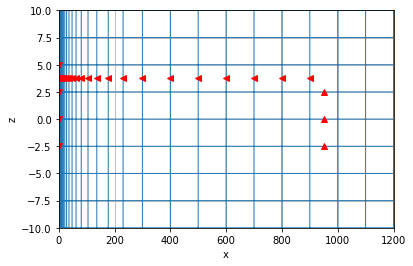

In [17]:
fig, ax = plt.subplots(1, 1)
meshGen.mesh.plotGrid(slice='theta', ax=ax)
src.plot(ax=ax)

ax.set_xlim([0., 1200.])
ax.set_ylim([-10., 10.])

## Simulation

In [18]:
sim_dict = {
    key: casingSim.run.SimulationTDEM(
        directory=m.directory, 
        formulation='j',
        meshGenerator=meshGen,
        modelParameters=m,
        src=src, 
    )
    for key, m in model_dict.items()
}

In [19]:
sim_dict

{'casing': <casingSimulations.run.SimulationTDEM at 0xd1dafa278>}

uncomment the below to re-run the simulation

In [20]:
# uncomment to write out a simulation file to run on another machine
# for sim in sim_dict.values():
#     sim.write_py(include2D=False, includeDC=False)

In [21]:
if rerun is True: 
    fields_dict = {}
    for key, sim in sim_dict.items():
        fields_dict[key] = sim.run()

# Load the results

Download the stored file

In [22]:
if use_downsampled_results:
    f = "TDEM_fields_downsampled"
else:
    f = "TDEM_fields_response_1km"
    
download = Utils.download(
    "https://storage.googleapis.com/simpeg/heagy_2018_emcyl/{}.tar.gz".format(f)
)  
tar = tarfile.open(download, "r:*")
tar.extractall()
tar.close()

   saved to: /Users/lindseyjh/git/simpeg-research/heagy-2018-emcyl/notebooks/TDEM_fields_downsampled.tar.gz
Download completed!


load the results into memory

In [23]:
if use_downsampled_results:
    jSolution = np.load(f + os.path.sep + 'fields.npy')
    
    times = np.load(f + os.path.sep + 'times.npy')    
    timesteps = np.hstack(np.diff(times))
    
    for sim in sim_dict.values():
        sim.prob.timeSteps = timesteps
    
else: 
    jSolution = np.load(simDir + os.path.sep + 'fields.npy')
    

re-populate the fields object (this takes a couple minutes)

In [24]:
%%time

if rerun is False: 
    # recreate the fields object
    fields_dict = {}

    for key, sim in sim_dict.items():
        sim.prob.model = physprops_dict[key].model
        fields_dict[key] = sim.prob.fieldsPair(sim.meshGenerator.mesh, sim.survey)
    
    fields_dict["casing"][:,'jSolution',:] = jSolution

CPU times: user 2min 38s, sys: 2.46 s, total: 2min 40s
Wall time: 2min 40s


# Plot Currents and Electric fields

These are widgets for interrogating the results. 
- `max_r`: maximum radial extent of the plot (m)
- `min_depth`: minimum depth (m)
- `max_depth`: maximum depth (m)
- `clim_min`: minimum colorbar limit. If `0`, then the colorbar limits are the plotting defaults
- `clim_max`: maximum colorbar limit. If `0`, then the colorbar limits are the plotting defaults
- `model_key`: model which we are viewing
- `view`: field or physical property that is plotted
- `prim_sec`: `primary` plots the background, `secondary` subtracts the `primary` response from the current value (note that if you select `background` and `secondary` the value will be zero and an error thrown
- `theta_ind`: index of the azimthal slice that we are viewing
- `time_ind`: index of the time-step we are viewing
- `show_mesh`: if checked, the mesh will be plotted on the right hand half of the plot
- `use_aspect`: if checked, the aspect ratio of the axes is set to 1 (eg. no vertical or horizontal exxageration) 
- `casing_outline`: draws the outline of the casing

In [25]:
viewer = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict
)

In [26]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":0.15,
        "theta_ind":3, 
        "view":"j"
    }
)

interactive(children=(FloatText(value=0.15, description='max_r'), FloatText(value=-10.0, description='min_dept…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [27]:
from matplotlib import rcParams
rcParams['font.size'] = 14

In [28]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":1.5*model.casing_l,
        "theta_ind":3,
        "view":"j"
    }, 
    figwidth=12
)

interactive(children=(FloatText(value=1500.0, description='max_r'), FloatText(value=-10.0, description='min_de…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

## Plan View 

In [29]:
viewer = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict
)

In [30]:
viewer.widget_depth_slice(
    fixed={"rotate": True, "figwidth":6, "k":10}, 
    defaults={
        "max_r":1500, "z_ind":400, "time_ind":1, "view":"j", "model_key":"casing", 
        "use_aspect":True
    }
)

interactive(children=(FloatText(value=1500.0, description='max_r'), FloatText(value=0.0, description='clim_min…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

## Figure 7

Lots of plotting code so that the look nice!

In [32]:
fields_dict2 = {}
sim_dict2 = {}

for key, sim in sim_dict.items():
    sim_dict2[key] = sim.copy()
    sim_dict2[key]._prob = sim._prob
    sim_dict2[key]._survey = sim._survey

if use_downsampled_results:
    f = "TDEM_fields_publication"
    if not os.path.isdir(f):
        download = Utils.download(
            "https://storage.googleapis.com/simpeg/heagy_2018_emcyl/{}.tar.gz".format(f)
        )  
        tar = tarfile.open(download, "r:*")
        tar.extractall()
        tar.close()
        
    jSolution = np.load(f + os.path.sep + 'fields.npy')
#     jSolution_background = np.load(f + os.path.sep + 'fields_background.npy')
    
    times = np.load(f + os.path.sep + 'times.npy')    
    timesteps = np.hstack(np.diff(times))
    
    plt_times = np.arange(0, len(times))
    
    for sim in sim_dict2.values():
        sim.prob.timeSteps = timesteps

    # recreate the fields object
    for key, sim in sim_dict2.items():
        sim.prob.model = physprops_dict[key].model
        fields_dict2[key] = sim.prob.fieldsPair(sim.meshGenerator.mesh, sim.survey)    
        
    fields_dict2["casing"][:,'jSolution',:] = jSolution
#     fields_dict2["background"][:,'jSolution',:] = jSolution_background
        
else:
    plt_times = [0, 10, 28, 73, 118, 136]
    fields_dict2 = fields_dict

In [33]:
from matplotlib import rcParams
from matplotlib import gridspec
rcParams['font.size'] = 24

In [34]:
viewer2 = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict2, fields_dict=fields_dict2
)

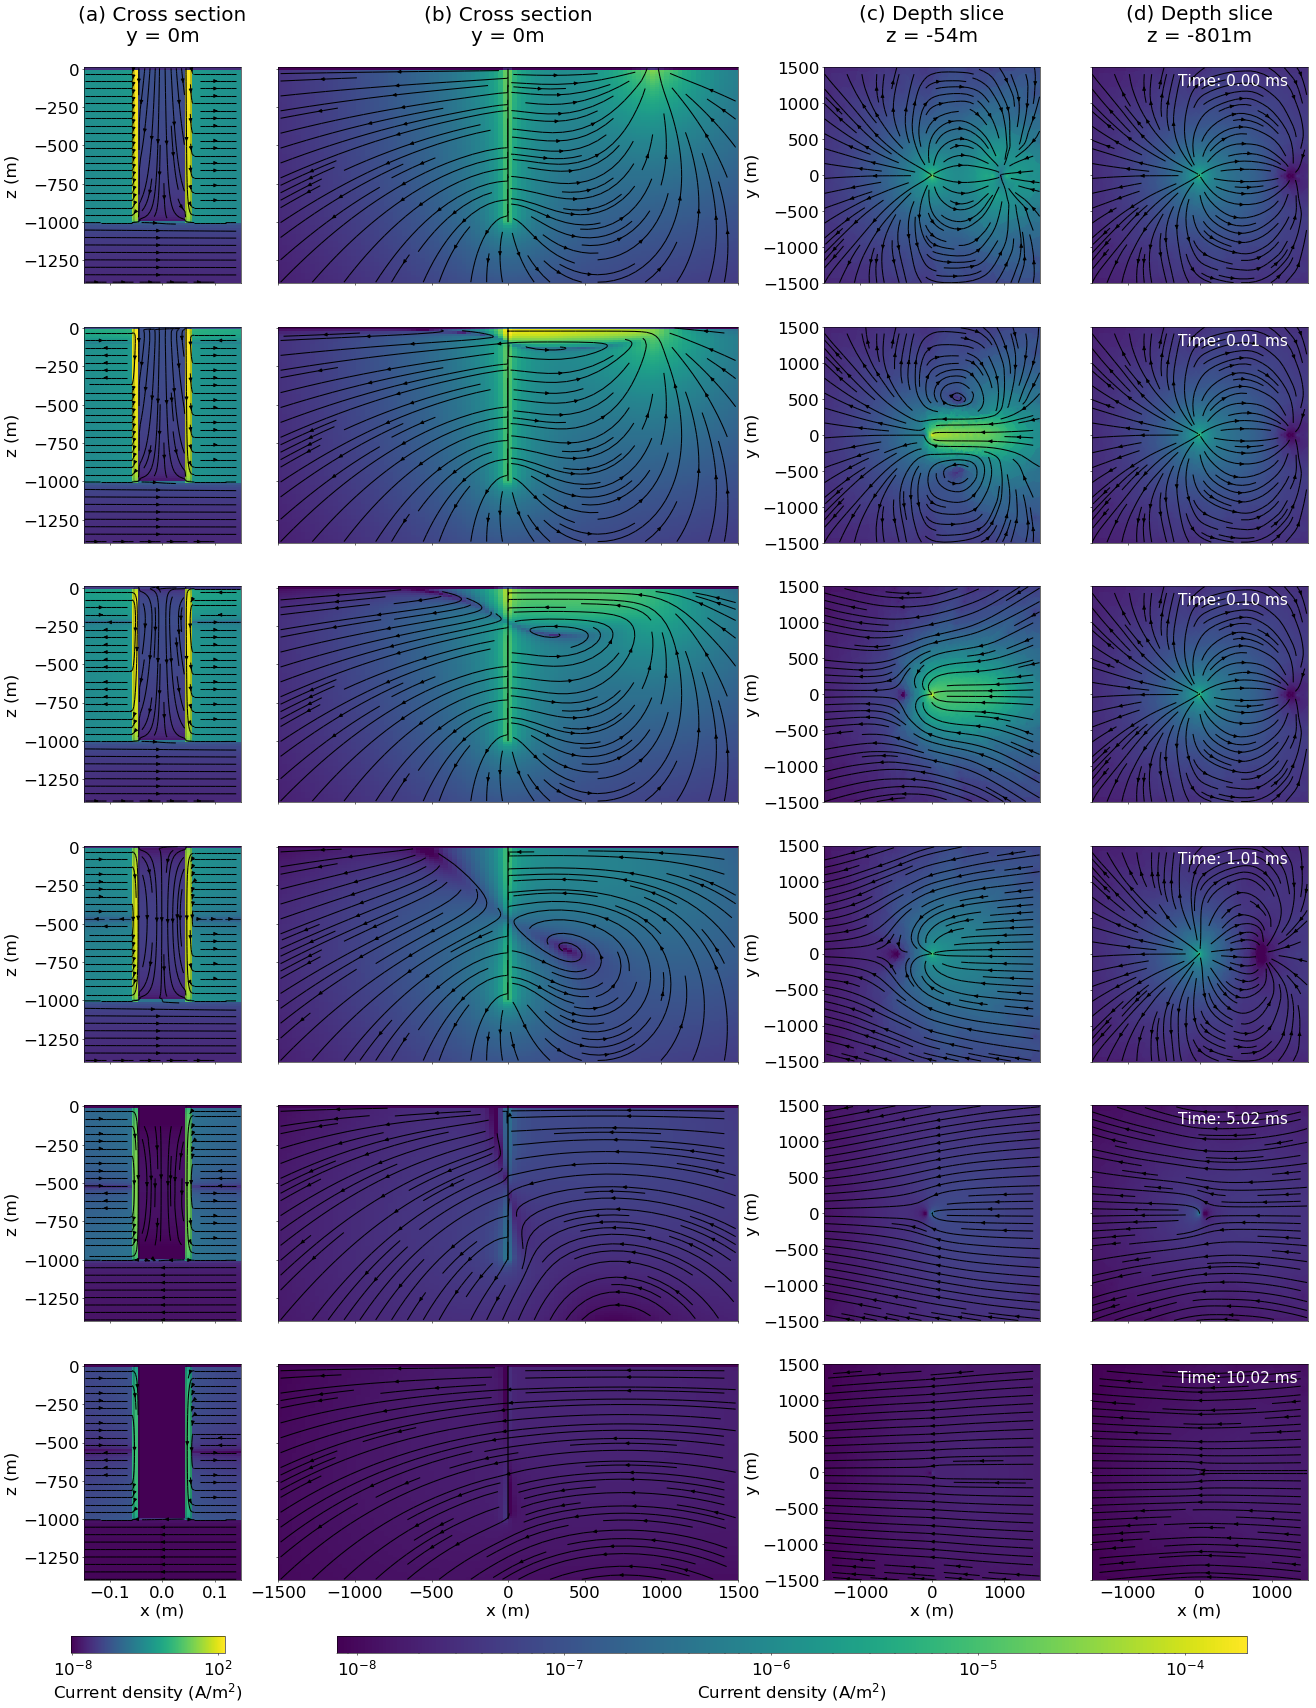

In [35]:
# mod = ['3D']
clim_max = 2e-4 
clim_min = 8e-9
clim = np.r_[clim_min, clim_max]

clim_max_casing = 3e2
clim_min_casing = 8e-9
clim_casing = np.r_[clim_min_casing, clim_max_casing]

max_depth = 1.4*casing_l
max_r_casing = 0.149
top=10.,

xlim = 1500.*np.r_[-1., 1.]

zinds = [400, 101]

x_ticks = [0, -500, -1000, -1500]

# fig, ax = plt.subplots(4, len(plt_times), figsize )

fig = plt.figure(figsize=(28, 5.5*len(plt_times)), dpi=50) 
fig.subplots_adjust(bottom=0.8)

gs = gridspec.GridSpec(len(plt_times), 4, width_ratios=[1, 4, 2, 2]) 
ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*4)]

for i, tind in enumerate(plt_times):
    
    ax0 = ax[i*4 + 1]
    ax1 = ax[i*4 + 2]
    ax2 = ax[i*4 + 3]
    ax3 = ax[i*4]
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax0, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key='casing', show_cb=False, use_aspect=True,
        casing_outline=True
    )
        
    
    # plot depth slice above
    for a, z_ind in zip([ax1, ax2], zinds):
        out = viewer2.plot_depth_slice(
            xlim=xlim, ylim=xlim, clim=clim,
            ax=a, z_ind=z_ind, model_key='casing', view='j',
            show_cb=False, time_ind=tind, rotate=True
        )
    
    ax2.text(-300, 1250, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=22)

    
    # zoomed in plot
    # currents in the formation
    out_casing = viewer2.plot_cross_section(
        ax=ax3, clim=clim_casing, zlim=np.r_[-max_depth, top],
        xlim=max_r_casing*np.r_[-1., 1.],
        view='j', theta_ind=3, time_ind=tind, 
        model_key='casing', show_cb=False, casing_outline=True
    )
    ax3.set_ylim(np.r_[-max_depth, top])
    ax3.set_ylabel('z (m)')
#     ax3.set_yticks(z_ticks)
    
    for a in [ax0, ax1, ax2, ax3]:
        a.set_title('')
        if a != ax3: 
            a.set_aspect(1)
            
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
        if a in [ax2, ax0]:
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))
    
        if a == ax1:
            a.set_ylabel('y (m)')
        
            
    if tind == 0:
        ax0.set_title('(b) Cross section\ny = 0m\n')
        ax1.set_title('(c) Depth slice\nz = {:1.0f}m\n'.format(sim.prob.mesh.vectorCCz[zinds[0]]))
        ax2.set_title('(d) Depth slice\nz = {:1.0f}m\n'.format(sim.prob.mesh.vectorCCz[zinds[1]])) 
        ax3.set_title('(a) Cross section\ny = 0m\n')
        
plt.tight_layout()

cbar_ax = fig.add_axes([0.25, -0.01, 0.65, 0.01])
cb = plt.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Current density (A/m$^2$)')

cbar_ax2 = fig.add_axes([0.06, -0.01, 0.11, 0.01])
cb2 = plt.colorbar(out_casing[0], cbar_ax2, orientation='horizontal')
cb2.set_label('Current density (A/m$^2$)')
cb2.set_ticks([1e-8, 1e2])
cb2.update_ticks()

plt.show()

In [36]:
fig.savefig('../figures/tdem_currents', bbox_inches='tight', dpi=300)
fig.savefig('../arxiv-figures/tdem_currents', bbox_inches='tight', dpi=150)

## Make movie

In [37]:
make_movie = False

In [38]:
def plot_currents(tind, show_cb, ax):
    out = viewer2.plot_cross_section(
        ax=ax, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key='casing', show_cb=show_cb, use_aspect=True,
        casing_outline=True
    )
    ax.set_title('')
    ax.text(-1400, -100, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=22)
    
    return out

(<matplotlib.collections.QuadMesh at 0xd3df5fe10>,
 <matplotlib.colorbar.Colorbar at 0xd30730940>)

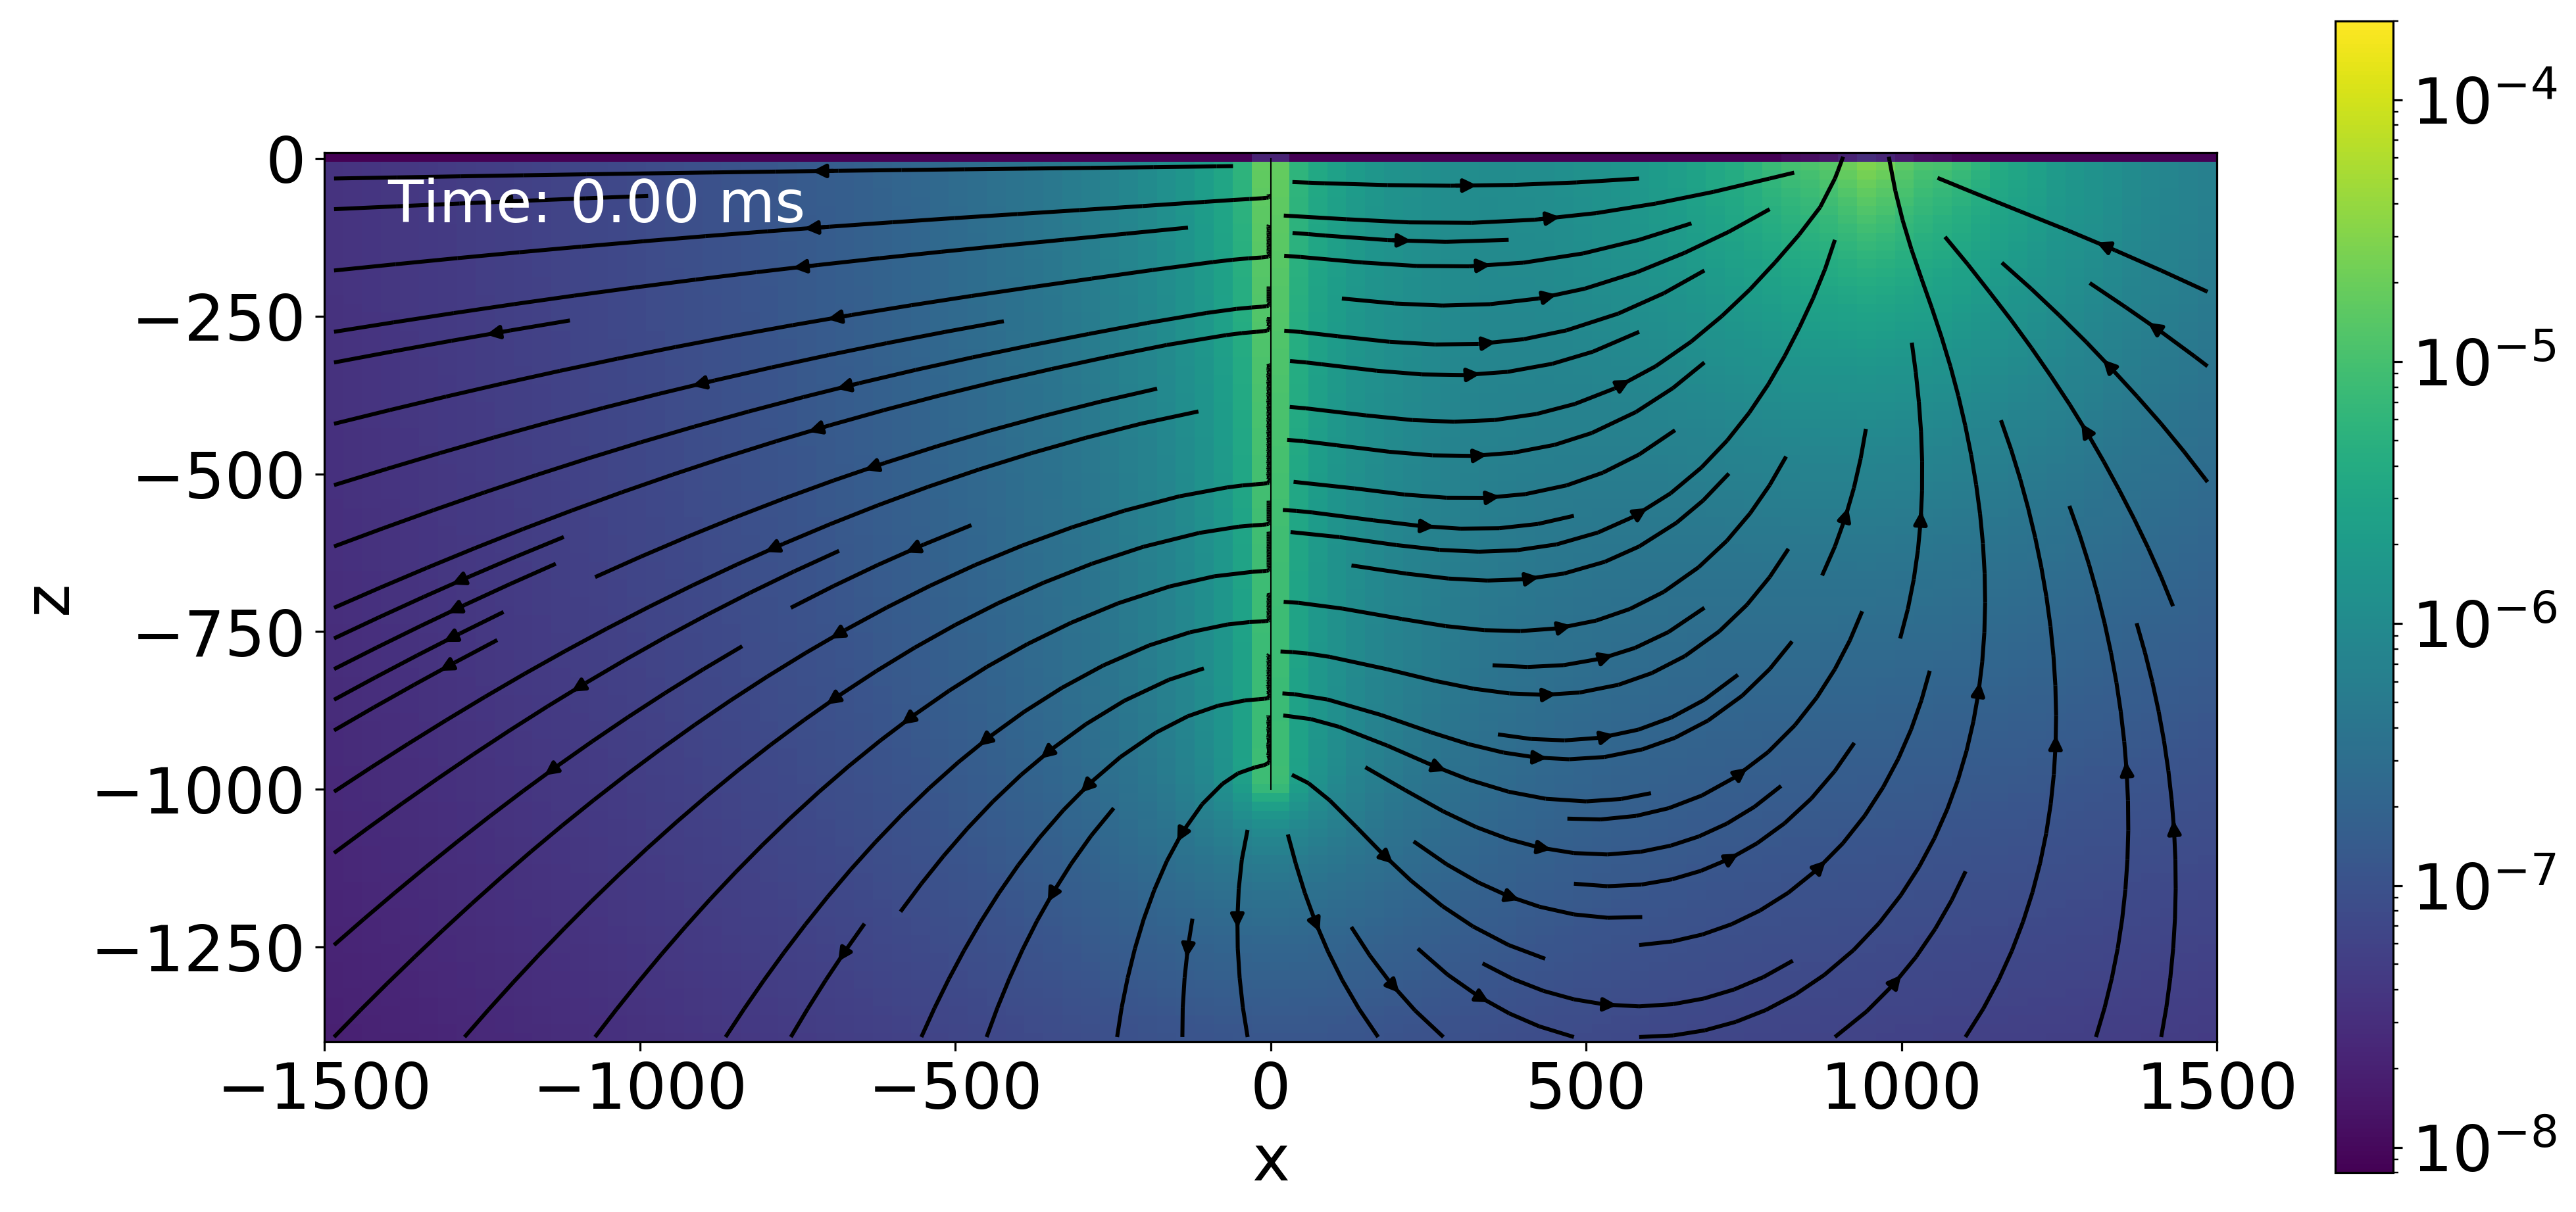

In [39]:
fig, ax = plt.subplots(1, 1, figsize = (16,8), dpi=290)
plot_currents(0, True, ax)

In [40]:
import ipywidgets 
from IPython.display import HTML
from matplotlib import animation, collections

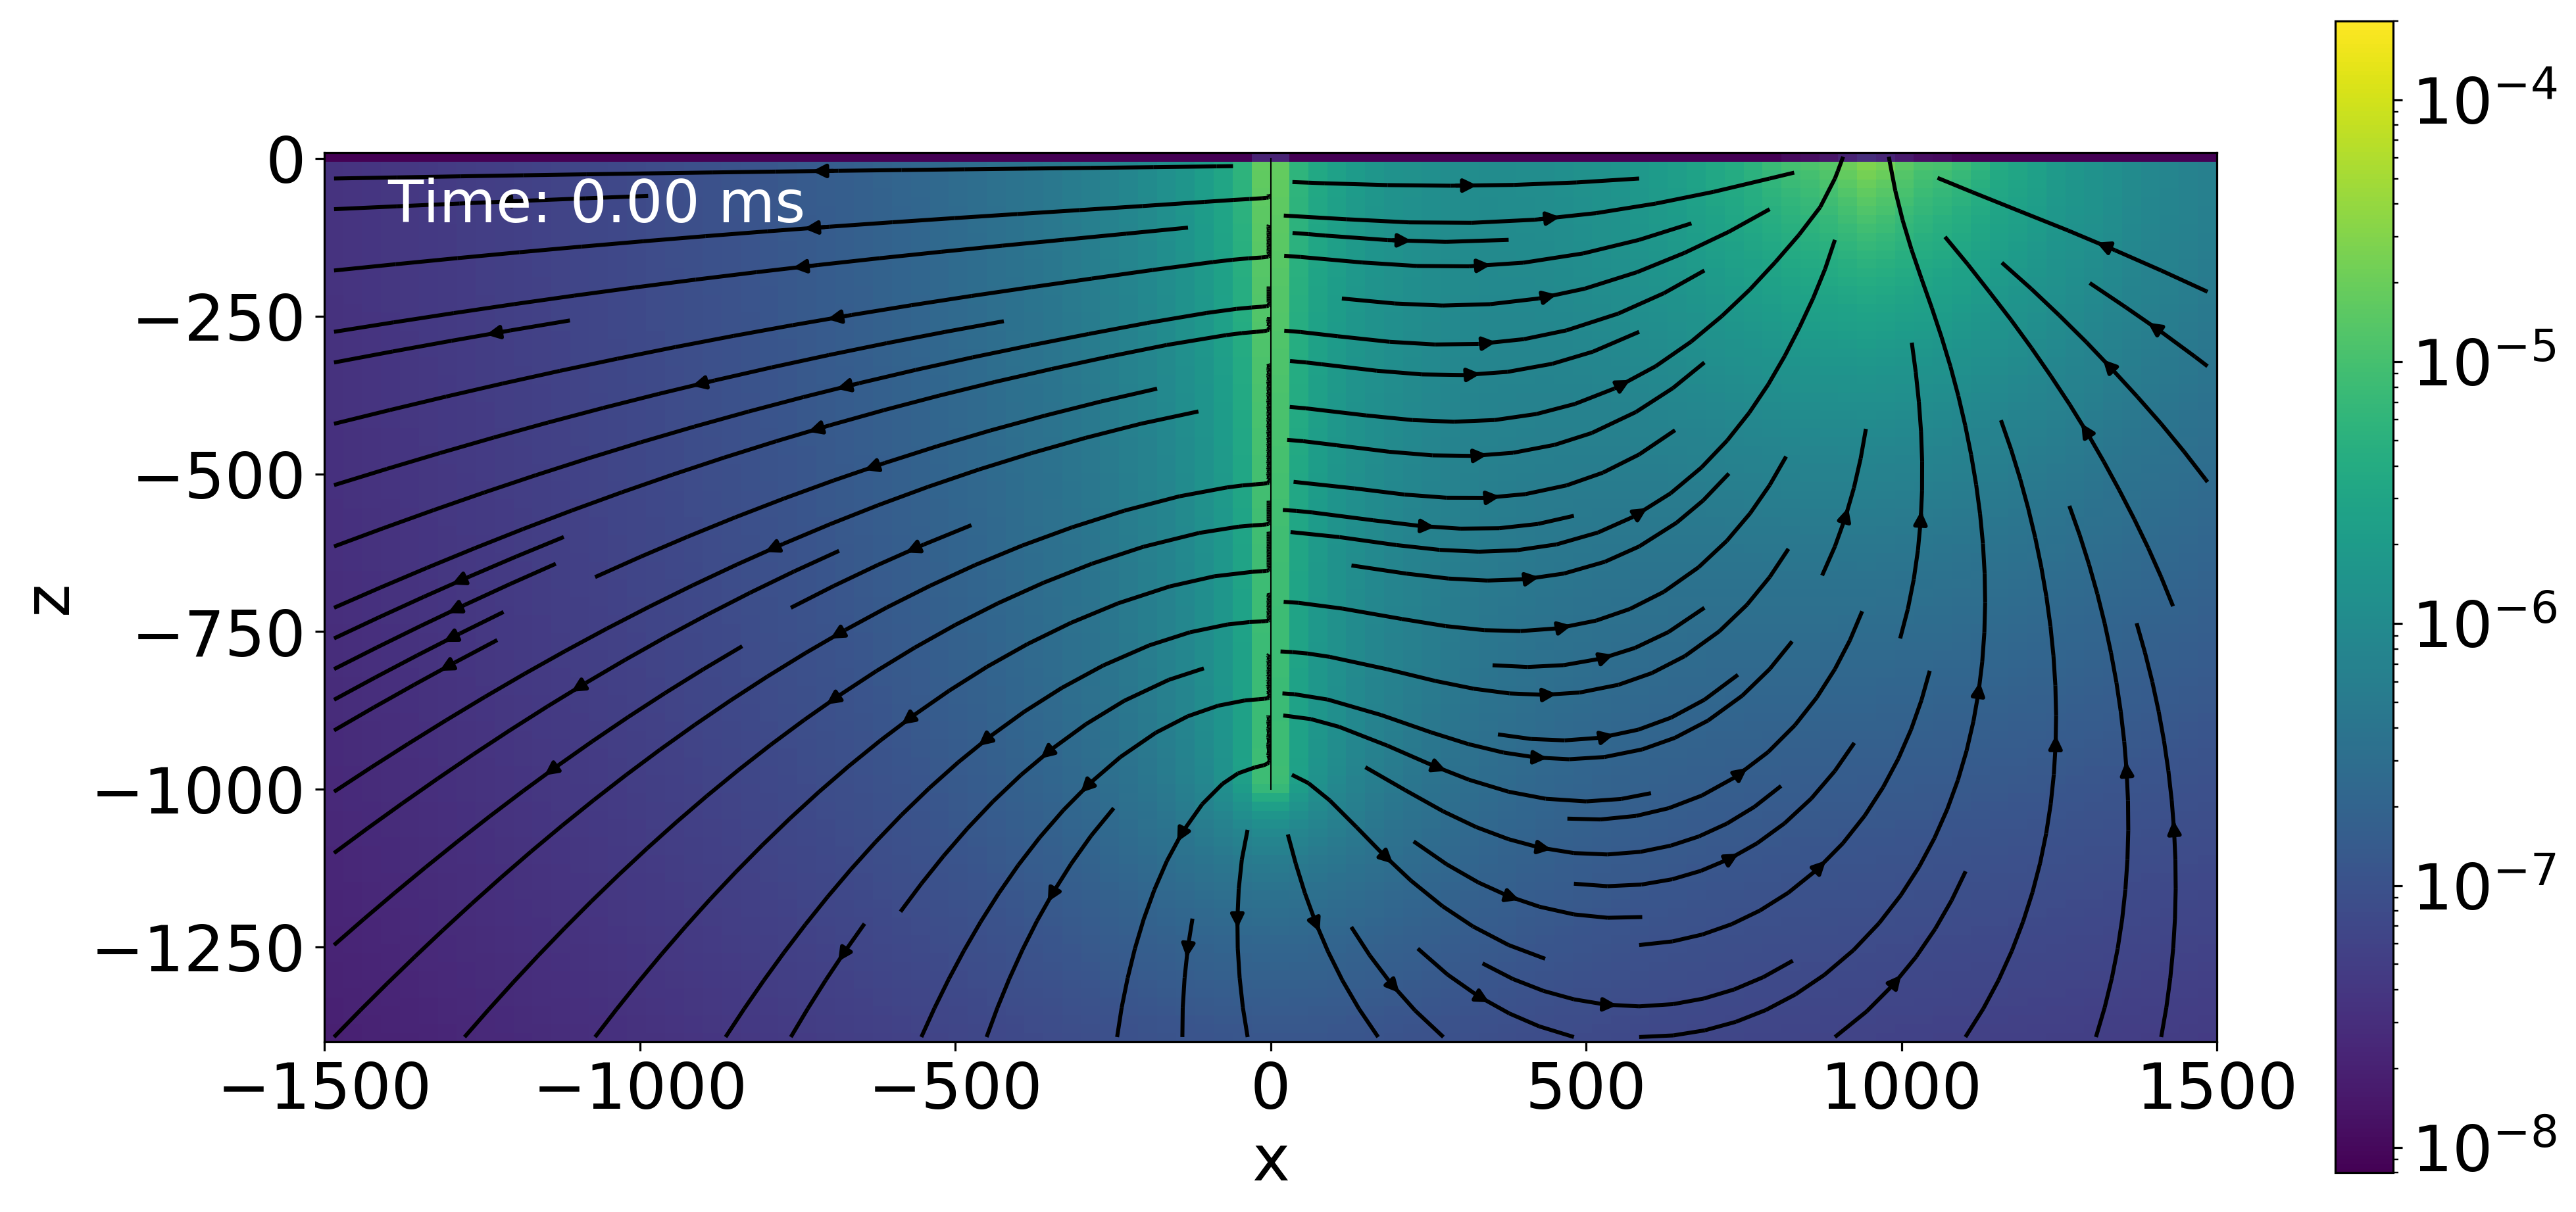

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (16,8), dpi=290)
out = plot_currents(tind=0, ax=ax, show_cb=True)

def init():
    [o.set_array(None) for o in out if isinstance(o, collections.QuadMesh)]
    return out

def update(t):
    ax.patches = []
    ax.lines = []
    ax.clear()
    return plot_currents(tind=t, show_cb=False, ax=ax)

if make_movie is True:
    ani = animation.FuncAnimation(fig, update, np.arange(0, 136), init_func=init, blit=False)

    ani.save(
        "../figures/currents2.mp4", writer="ffmpeg", fps=3, dpi=250, bitrate=0, 
        metadata={"title":"TDEM casing currents", "artist":"Lindsey Heagy"}
    )

In [42]:
if make_movie is True:
    anihtml = ani.to_jshtml(fps=2)
    HTML(anihtml)

## Print code versions

In [43]:
versions('HTML')